## Updates from first iteration:
### Added validation set, now Train/Test/Valid : 8/1/1
### Added Precision Recall, F1 score from sklearn
To start the project run all but the last cell where you can specify the parameters and hyper parameters of the GAT.

We start with installing torch-geometric, networkx, and matplotlib

# Warning: Current configuration is set to distance=30, error rate=40% (2d-1)^2 + (d//2)(4) = 3541 nodes). This will take all day with current set hyper parameters so please look at results before running. Last test run did not complete before timeout.

*Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.4984

However

*Best: Precision: 0.9855, Recall: 0.9855, F1 Score: 0.9855

GAT(
  (conv1): GATConv(3, 32, heads=8)
  (convs): ModuleList(
    (0-1): 2 x GATConv(256, 32, heads=8)
  )
  (conv2): GATConv(256, 4, heads=1)
)

Hyperparameters: {'hidden_size': 32, 'num_layers': 4, 'lr': [0.01, 0.001], 'weight_decay': [8e-4, 1e-4]}

In [ ]:
!pip install torch-geometric networkx matplotlib

This is the surface code generator of a specified distance and error rate.

In [ ]:
import math
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from sklearn.model_selection import train_test_split

class ToricSurfaceCodeGenerator:
  def __init__(self, distance, error_rate):
    self.distance = distance
    self.error_rate = error_rate
    self.grid_size = 2 * distance - 1
    self.num_nodes = self.grid_size ** 2
    self.num_ancilla = self.num_nodes // 2
    self.ears_per_side = distance // 2
    self.data_idx, self.ancilla_Z_idx, self.ancilla_X_idx = self.getQubitIndexList()
    self.node_types = ['Data' if i % 2 == 0 else 'Ancilla' for i in range(self.num_nodes)]
    self.ancilla_elephant_ears = self.create_elephant_ears() # create these after so they appear at the end
    self.edge_index = self.generate_edge_index()
    self.edge_index_exteneded_ears = self.add_EE_to_edge_index()
    self.errors = [] # Ground Truth
    self.input_data = np.zeros(self.num_nodes, dtype=int)
    self.ancilla_states = np.zeros(self.num_ancilla, dtype=bool)  # Initialize ancilla qubit states

  def add_EE_to_edge_index(self):
    additional_edges = []
    index_list = list(self.ancilla_elephant_ears)

    n_nodes = int(self.num_nodes-len(self.ancilla_elephant_ears))

    # handle elephant ears
    # Top-Row - should be all Z
    edges = [node for node in self.data_idx if node <= self.grid_size]

    paired_edges = []
    if len(edges) % 2 != 0:
      edges = edges[:-1]  # Drop the last element if the count is odd
    for i in range(0, len(edges), 2):
      paired_edges.append([edges[i], edges[i + 1]])

    # for every Z in length of side, add edges
    for paired_edge in paired_edges:
      additional_edges.append([index_list[0], paired_edge[0]])
      additional_edges.append([index_list[0], paired_edge[1]])
      index_list.pop(0)

    # Right-Col - should be all X
    edges = []
    for row in range(0, self.grid_size, 2):
      end_of_row_index = ((row+1)*self.grid_size) - 1
      edges.append(end_of_row_index)

    paired_edges = []
    if len(edges) % 2 != 0:
      edges = edges[:-1]  # Drop the last element if the count is odd
    for i in range(0, len(edges), 2):
      paired_edges.append([edges[i], edges[i + 1]])

    for i, paired_edge in enumerate(paired_edges):
      additional_edges.append([index_list[0], paired_edge[0]])
      additional_edges.append([index_list[0], paired_edge[1]])
      index_list.pop(0)

    # Bottom-Row - should be all Z
    data_index_reversed = self.data_idx
    data_index_reversed.reverse()

    edges = [node for node in data_index_reversed if node >= (n_nodes - self.grid_size)]

    paired_edges = []
    if len(edges) % 2 != 0:
      edges = edges[:-1]  # Drop the last element if the count is odd
    for i in range(0, len(edges), 2):
      paired_edges.append([edges[i], edges[i + 1]])

    for paired_edge in paired_edges:
      additional_edges.append([index_list[0], paired_edge[0]])
      additional_edges.append([index_list[0], paired_edge[1]])
      index_list.pop(0)

    # Left-Col - should be all X
    data_index_reversed = [x for x in range(self.grid_size)]
    data_index_reversed.reverse()

    edges = []
    reversed_range = range(self.grid_size - 2 if self.grid_size % 2 == 0 else self.grid_size - 1, -1, -2)

    for row in reversed_range:
      end_of_row_index = (row)*self.grid_size
      edges.append(end_of_row_index)

    paired_edges = []
    if len(edges) % 2 != 0:
      edges = edges[:-1]  # Drop the last element if the count is odd
    for i in range(0, len(edges), 2):
      paired_edges.append([edges[i], edges[i + 1]])

    for paired_edge in paired_edges:
      additional_edges.append([index_list[0], paired_edge[0]])
      additional_edges.append([index_list[0], paired_edge[1]])
      index_list.pop(0)

    # Add additional pairs of edges
    # print("additional_edges:", additional_edges)
    # additional_edges = [[24, 0], [24, 2]]  for the 24th qubit
    for edge in additional_edges:
      self.edge_index = torch.cat((self.edge_index, torch.tensor(edge).unsqueeze(1)), dim=1)
    return 0

  def create_elephant_ears(self):
    EE_ancilla_types = []
    EE_ancilla_index = []
    # ancilla 1 is X so we start with Z going from Top-Left clockwise
    # [[ears_per_side], [ears_per_side], [ears_per_side], [ears_per_side]]
    # [Z, Z, Z ... X, X, X ..., Z, Z, Z ..., X, X, X]
    num_of_ZX_sides = 2
    for i in range(num_of_ZX_sides):
      EE_ancilla_types.extend(['Z'] * self.ears_per_side)
      EE_ancilla_types.extend(['X'] * self.ears_per_side)
    extra_ancilla = len(EE_ancilla_types)

    for i, node in enumerate(EE_ancilla_types):
      if node == 'Z':
        self.ancilla_Z_idx.append(self.num_nodes + i)
        EE_ancilla_index.append(self.num_nodes + i)
      if node == 'X':
        self.ancilla_X_idx.append(self.num_nodes + i)
        EE_ancilla_index.append(self.num_nodes + i)

    self.num_nodes += extra_ancilla
    for node in EE_ancilla_index:
      self.node_types.append('Ancilla')
    return EE_ancilla_index

  def getQubitIndexList(self):
    lattice = np.zeros([self.grid_size, self.grid_size], int)
    count=0
    data_qubit_index = []
    all_ancilla_index = []
    za_qubit_index = []
    xa_qubit_index = []

    for i in range(len(lattice[0])):
      for j in range(len(lattice[0])):
        lattice[i][j] = count
        count +=1

    for i, r in enumerate(lattice):
      for j, d in enumerate(lattice):
        # if it's an even row then it starts with a data qubit
        if i % 2 == 0:
          # if it's an even number it's data qubit
          if j % 2 == 0:
            data_qubit_index.append(lattice[i][j])
          else: # it's an odd number it's alternating ancilla
            all_ancilla_index.append(lattice[i][j])
        else: # if it's odd it starts with ancilla
          if j % 2 == 0:
            all_ancilla_index.append(lattice[i][j])
          else:
            data_qubit_index.append(lattice[i][j])

    smallest_ancilla_row = self.grid_size // 2
    largest_ancilla_row = math.ceil(self.grid_size / 2)

    i = 0
    while i < len(all_ancilla_index):
      xa_qubit_index.extend(all_ancilla_index[i:i+smallest_ancilla_row])
      za_qubit_index.extend(all_ancilla_index[i+smallest_ancilla_row:i+self.grid_size])
      i += self.grid_size

    return data_qubit_index, za_qubit_index, xa_qubit_index

  def generate_edge_index(self):
    edges = []
    for i in range(self.grid_size):
      for j in range(self.grid_size):
        idx = i * self.grid_size + j
        if j < self.grid_size - 1:  # Horizontal edges
          edges.append([idx, idx + 1])
        if i < self.grid_size - 1:  # Vertical edges
          edges.append([idx, idx + self.grid_size])
    edges = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return edges

  def apply_errors(self):
    for i in range(self.num_nodes):
      if np.random.random() < self.error_rate:
        error_type = np.random.choice(['X', 'Z', 'Y'])  # Randomly choose error type
        self.errors.append(error_type)
      else:
        self.errors.append('0')

  def getEdgesForNode(self, node):
    edges = []
    edges.append(self.edge_index[:, self.edge_index[0] == node])
    edges.append(self.edge_index[:, self.edge_index[1] == node])
    flattened_edges = [torch.flatten(edge) for edge in edges]
    flattened_edges = torch.cat(flattened_edges)
    filtered_edges = flattened_edges[flattened_edges != node]
    return filtered_edges

  def update_ancilla_states(self):
    # errrors get applied to data qubits first that effect ancilla, then ancilla applies errors ontop of those errors
    # Iterate over ground truth for errors
    # tensor([[ 0,  0,  1,  1,  2,  2,  3,... ],
     #        [ 1,  5,  2,  6,  3,  7,  4,... ]])
    for node in self.data_idx:
      if self.errors[node] != '0': #error
      # get edges of data node to update ancilla
        error_id = self.errors[node]
        edges_for_node = self.getEdgesForNode(node)
        if error_id == 'X':
          for edge in edges_for_node:
            if edge in self.ancilla_X_idx:
              self.input_data[edge] += 1
        elif error_id == 'Z':
          for edge in edges_for_node:
            if edge in self.ancilla_Z_idx:
              self.input_data[edge] += 1
        elif error_id == 'Y':
          for edge in edges_for_node:
            self.input_data[edge] += 1
    for i, node in enumerate(self.input_data):
      if node % 2 == 0:
        self.input_data[i] = 0
      elif node % 2 == 1:
        self.input_data[i] = 1

    # data qubit errors done now ancilla
    for node in self.ancilla_X_idx:
      node_state = self.input_data[node]  # Current state of the ancilla qubit: 0 or 1
      error_id = self.errors[node]  # Error that occurred when measured: 'X' or 'Y' or 'Z'
      if error_id == 'X' or error_id == 'Y':  # Both X and Y errors change the state from 0 to 1 or from 1 to 0
        self.input_data[node] = 1 - node_state  # Flip the state from 0 to 1 or from 1 to 0

    # Handling ancilla Z indexes
    for node in self.ancilla_Z_idx:
      node_state = self.input_data[node]  # Current state of the ancilla qubit: 0 or 1
      error_id = self.errors[node]  # Error that occurred when measured: 'X' or 'Y' or 'Z'
      if error_id == 'Y':  # Only Y errors change the state from 0 to 1 or from 1 to 0 for ancilla Z indexes
        self.input_data[node] = 1 - node_state  # Flip the state from 0 to 1 or from 1 to 0
    for i, node in enumerate(self.input_data):
      if node % 2 == 0:
        self.input_data[i] = 0
      elif node % 2 == 1:
        self.input_data[i] = 1

  def get_node_features(self):
    error_labels = {'X': 1, 'Z': 2, 'Y': 3, '0': 0}
    converted_errors = [error_labels[error] for error in self.errors]
    # node embedding will be [node type (Data or Ancilla), Measurement (on Ancilla), Ground Truth]
    x = torch.tensor([[self.node_types[i] == 'Data', self.input_data[i], converted_errors[i]]
                         for i in range(self.num_nodes)], dtype=torch.float)
    return x

Generate the graph data and edge index to be used in a custom dataset

In [ ]:
def generate_graph_data(distance, error_rate):
    generator = ToricSurfaceCodeGenerator(distance, error_rate)
    generator.apply_errors()
    generator.update_ancilla_states()  # Update ancilla states based on data errors
    x = generator.get_node_features()
    edge_index = generator.edge_index

    return x, edge_index

for plotting our accuracy and loss after each combination of parameters

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(metrics):
    epochs = range(1, len(metrics['loss']) + 1)

    # Plotting Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metrics['loss'], 'b', label='Training loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metrics['accuracy'], 'r', label='Training accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
  def __init__(self, num_features, hidden_channels, num_classes, num_layers, heads):
    super(GAT, self).__init__()
    self.conv1 = GATConv(num_features, hidden_channels, heads=heads)
    self.convs = torch.nn.ModuleList()
    for _ in range(num_layers - 2):
      self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads))
    self.conv2 = GATConv(hidden_channels * heads, num_classes, heads=1)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = F.elu(x)
    for conv in self.convs:
      x = conv(x, edge_index)
      x = F.elu(x)
    x = self.conv2(x, edge_index)
    return F.log_softmax(x, dim=1)


def train(model, optimizer, criterion, train_graphs):
  model.train()
  total_loss = 0
  total_correct = 0
  total_examples = 0
  for graph_data in train_graphs:
    optimizer.zero_grad()
    out = model(graph_data.x, graph_data.edge_index)
    loss = criterion(out, graph_data.y)
    loss.backward()
    optimizer.step()

    # Compute accuracy
    predicted = out.argmax(dim=1)
    correct = predicted.eq(graph_data.y)
    total_correct += correct.sum().item()
    total_examples += graph_data.num_nodes

    total_loss += loss.item()
  # Compute average loss and accuracy
  avg_loss = total_loss / len(train_graphs)
  accuracy = total_correct / total_examples
  return avg_loss, accuracy

def test(model, test_graphs):
  model.eval()
  total_correct = 0
  total_test_samples = 0
  for graph_data in test_graphs:
    out = model(graph_data.x, graph_data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    correct = pred == graph_data.y  # Check against ground-truth labels.
    total_correct += correct.sum().item()
    total_test_samples += len(graph_data.y)  # Count all labeled nodes in the graph
  test_acc = total_correct / total_test_samples  # Derive ratio of correct predictions.
  return test_acc

In order to se the graphs how we want to we need to create our own torch dataset here

In [ ]:
# Create our own dataset from the graphs
class CustomDataset(Dataset):
  def __init__(self, num_graphs, distance, error_rate):
    super(CustomDataset, self).__init__()
    self.graph_data_list = []

    for _ in range(num_graphs):
      x, edge_index = generate_graph_data(distance, error_rate)
      graph_data = Data(x=x, edge_index=edge_index, y = x[:, 2].long())

      self.graph_data_list.append(graph_data)

  def __len__(self):
    return len(self.graph_data_list)

  def __getitem__(self, idx):
    return self.graph_data_list[idx]

In [ ]:
import random
from sklearn.metrics import precision_score, recall_score, f1_score

def generate_multiple_graphs(num_graphs, distances, error_rates, hyperparameters):
    # generate num_graphs for each distance and multiple error rates
    graph_data_list = []
    for distance in distances:
      print("Starting with distance: ", distance)
      for error_rate in error_rates:
        print("Starting with error rate: ", error_rate)
        graph_data = []
        dataset = CustomDataset(num_graphs, distance, error_rate)

        # start the GNN for graph_data
        # split for training and testing
        dataset_list = list(dataset)
        random.shuffle(dataset_list)  # Shuffle the dataset
        train_size = int(0.8 * len(dataset_list))
        train_graphs = dataset_list[:train_size]
        test_graphs = dataset_list[train_size:]

        # Further split the testing set into testing and validation sets (50-50 split)
        test_size = len(test_graphs) // 2
        val_graphs = test_graphs[:test_size]
        test_graphs = test_graphs[test_size:]



        best_accuracy = 0
        best_hyperparameters = None

        for hidden_size in hyperparameters['hidden_size']:
          for num_layers in hyperparameters['num_layers']:
            for lr in hyperparameters['lr']:
              for weight_decay in hyperparameters['weight_decay']:
                num_features = dataset[0].num_features
                num_classes = dataset.num_classes
                model = GAT(num_features=num_features, hidden_channels=hidden_size, num_classes=num_classes, num_layers=num_layers, heads=hyperparameters['heads'])
                print(model)
                optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
                criterion = torch.nn.CrossEntropyLoss()

                losses = []
                accuracies = []
                val_accuracies = []
                val_predictions = []  # Track predictions for validation set
                val_labels = []       # Track labels for validation set
                for epoch in range(1, hyperparameters['epochs']+1):
                  avg_loss, accuracy = train(model, optimizer, criterion, train_graphs)
                  losses.append(avg_loss)
                  accuracies.append(accuracy)
                  # Validate the model
                  val_accuracy = test(model, val_graphs)
                  val_accuracies.append(val_accuracy)

                  # Track predictions and labels for validation set
                  val_predictions = []
                  val_labels = []
                  for graph_data in val_graphs:
                    out = model(graph_data.x, graph_data.edge_index)
                    val_pred = out.argmax(dim=1)
                    val_predictions.append(val_pred.cpu().numpy())
                    val_labels.append(graph_data.y.cpu().numpy())

                  # Print and track validation accuracy
                  print(f'Epoch {epoch}, Val Accuracy: {val_accuracy:.4f}')

                # Compute Precision, Recall, and F1 Score
                val_predictions = np.concatenate(val_predictions)
                val_labels = np.concatenate(val_labels)
                precision = precision_score(val_labels, val_predictions, average='macro')
                recall = recall_score(val_labels, val_predictions, average='macro')
                f1 = f1_score(val_labels, val_predictions, average='macro')
                print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

                plot_metrics({'loss': losses, 'accuracy': accuracies})
                # Find the best validation accuracy and its corresponding hyperparameters
                max_val_accuracy = max(val_accuracies)
                if max_val_accuracy > best_accuracy:
                  best_accuracy = max_val_accuracy
                  best_hyperparameters = {
                    'hidden_size': hidden_size,
                    'num_layers': num_layers,
                    'lr': lr,
                    'weight_decay': weight_decay
                  }

                print(f'Best Validation Accuracy: {best_accuracy:.4f}, Best Hyperparameters: {best_hyperparameters}')

                # Test the model using the best hyperparameters found so far
                if epoch == hyperparameters['epochs']:
                  model = GAT(num_features=num_features, hidden_channels=best_hyperparameters['hidden_size'], num_classes=num_classes, num_layers=best_hyperparameters['num_layers'], heads=hyperparameters['heads'])
                  optimizer = torch.optim.AdamW(model.parameters(), lr=best_hyperparameters['lr'], weight_decay=best_hyperparameters['weight_decay'])
                  test_accuracy = test(model, test_graphs)
                  print(f'Test Accuracy with Best Hyperparameters: {test_accuracy:.4f}')


        print(f'Distance: {distance}, Error Rate: {error_rate}, Hidden Size: {hidden_size}, Num Layers: {num_layers}, LR: {lr}, Weight Decay: {weight_decay}, Epoch: {epoch}, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
        print("Best Accuracy: ", best_accuracy, "Best Hyperparameters", best_hyperparameters)
    return best_accuracy, best_hyperparameters



Set parameters here, if they are in an arry you can add more than one paramter to test.

Starting with distance:  30
Starting with error rate:  0.4
GAT(
  (conv1): GATConv(3, 16, heads=8)
  (convs): ModuleList()
  (conv2): GATConv(128, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6299
Epoch 2, Val Accuracy: 0.7500
Epoch 3, Val Accuracy: 0.7660
Epoch 4, Val Accuracy: 0.7737
Epoch 5, Val Accuracy: 0.7772
Epoch 6, Val Accuracy: 0.7803
Epoch 7, Val Accuracy: 0.7822
Epoch 8, Val Accuracy: 0.7820
Epoch 9, Val Accuracy: 0.7832
Epoch 10, Val Accuracy: 0.7857
Epoch 11, Val Accuracy: 0.7886
Epoch 12, Val Accuracy: 0.7882
Epoch 13, Val Accuracy: 0.7874
Epoch 14, Val Accuracy: 0.7873
Epoch 15, Val Accuracy: 0.7859
Epoch 16, Val Accuracy: 0.7873
Epoch 17, Val Accuracy: 0.7882
Epoch 18, Val Accuracy: 0.7885
Epoch 19, Val Accuracy: 0.7900
Epoch 20, Val Accuracy: 0.7921
Epoch 21, Val Accuracy: 0.7930
Epoch 22, Val Accuracy: 0.7916
Epoch 23, Val Accuracy: 0.7906
Epoch 24, Val Accuracy: 0.7920
Epoch 25, Val Accuracy: 0.7928
Epoch 26, Val Accuracy: 0.7906
Epoch 27, Val Accuracy: 0.7907
Epoch 28, V

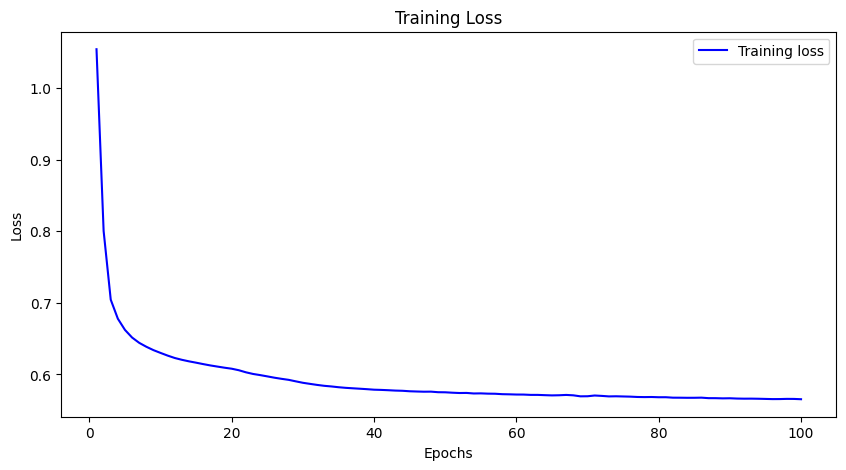

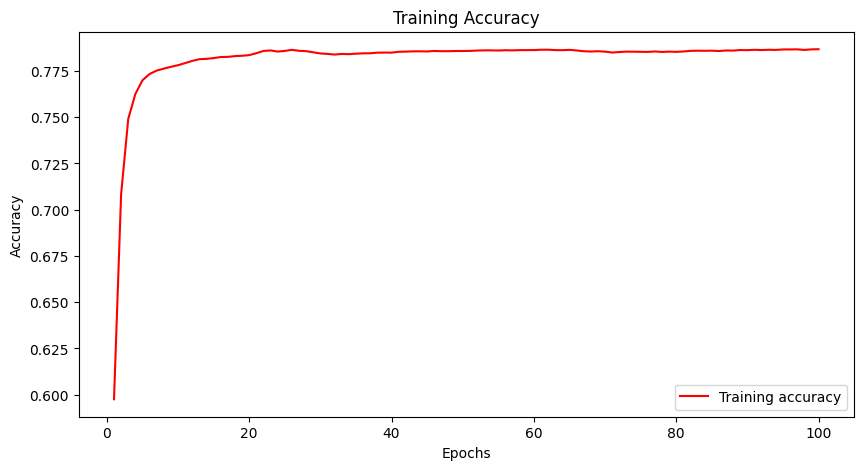

Best Validation Accuracy: 0.7930, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0008}
Test Accuracy with Best Hyperparameters: 0.1411
GAT(
  (conv1): GATConv(3, 16, heads=8)
  (convs): ModuleList()
  (conv2): GATConv(128, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6452
Epoch 2, Val Accuracy: 0.7648
Epoch 3, Val Accuracy: 0.8201
Epoch 4, Val Accuracy: 0.8393
Epoch 5, Val Accuracy: 0.8462
Epoch 6, Val Accuracy: 0.8577
Epoch 7, Val Accuracy: 0.8859
Epoch 8, Val Accuracy: 0.8989
Epoch 9, Val Accuracy: 0.9143
Epoch 10, Val Accuracy: 0.9188
Epoch 11, Val Accuracy: 0.9235
Epoch 12, Val Accuracy: 0.9320
Epoch 13, Val Accuracy: 0.9302
Epoch 14, Val Accuracy: 0.9398
Epoch 15, Val Accuracy: 0.9421
Epoch 16, Val Accuracy: 0.9519
Epoch 17, Val Accuracy: 0.9480
Epoch 18, Val Accuracy: 0.9400
Epoch 19, Val Accuracy: 0.9554
Epoch 20, Val Accuracy: 0.9692
Epoch 21, Val Accuracy: 0.9720
Epoch 22, Val Accuracy: 0.9740
Epoch 23, Val Accuracy: 0.9759
Epoch 24, Val Acc

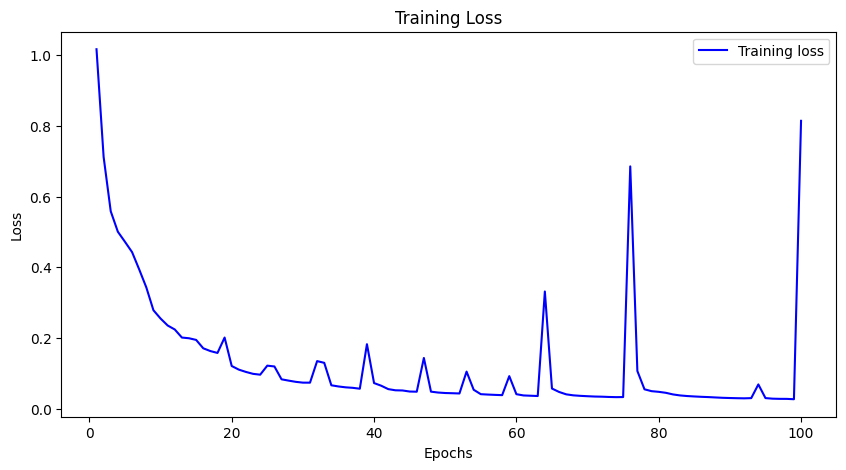

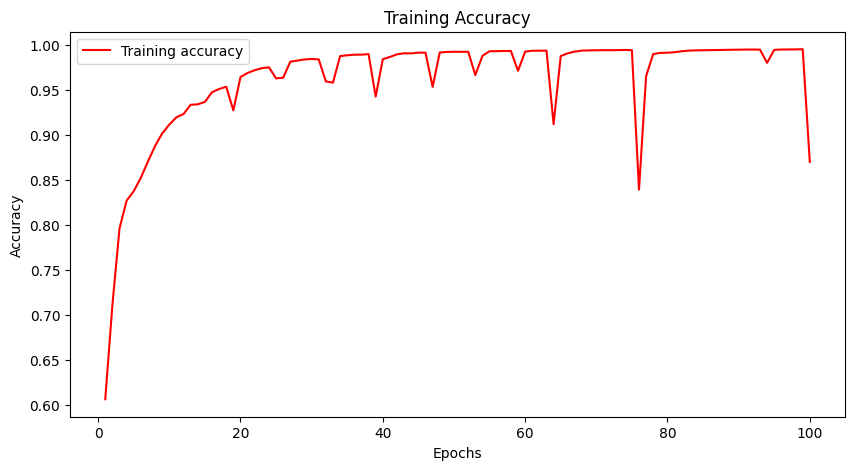

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.4984
GAT(
  (conv1): GATConv(3, 16, heads=8)
  (convs): ModuleList()
  (conv2): GATConv(128, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6037
Epoch 2, Val Accuracy: 0.6026
Epoch 3, Val Accuracy: 0.6026
Epoch 4, Val Accuracy: 0.6196
Epoch 5, Val Accuracy: 0.6654
Epoch 6, Val Accuracy: 0.7252
Epoch 7, Val Accuracy: 0.7936
Epoch 8, Val Accuracy: 0.7982
Epoch 9, Val Accuracy: 0.8034
Epoch 10, Val Accuracy: 0.8097
Epoch 11, Val Accuracy: 0.8156
Epoch 12, Val Accuracy: 0.8217
Epoch 13, Val Accuracy: 0.8268
Epoch 14, Val Accuracy: 0.8316
Epoch 15, Val Accuracy: 0.8402
Epoch 16, Val Accuracy: 0.8470
Epoch 17, Val Accuracy: 0.8488
Epoch 18, Val Accuracy: 0.8561
Epoch 19, Val Accuracy: 0.8588
Epoch 20, Val Accuracy: 0.8631
Epoch 21, Val Accuracy: 0.8659
Epoch 22, Val Accuracy: 0.8696
Epoch 23, Val Accuracy: 0.8724
Epoch 24, Val Acc

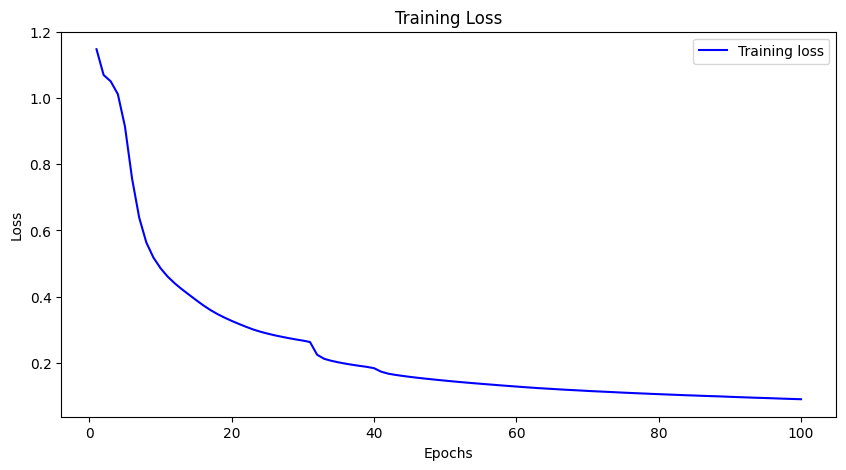

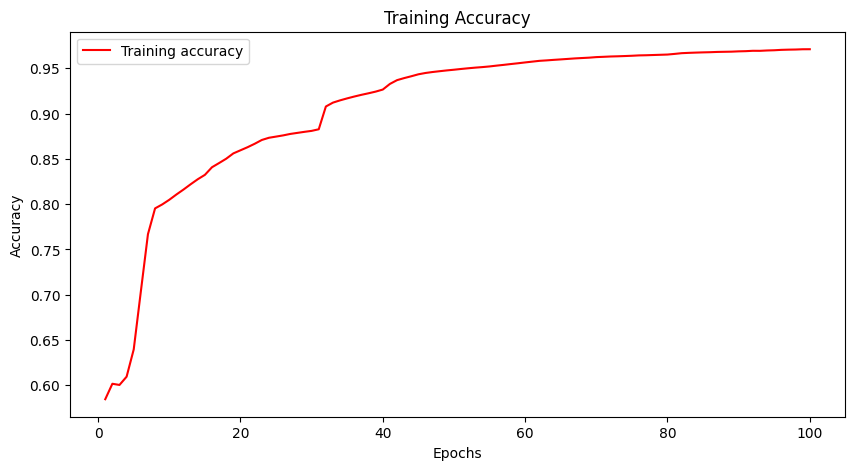

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.1213
GAT(
  (conv1): GATConv(3, 16, heads=8)
  (convs): ModuleList()
  (conv2): GATConv(128, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6036
Epoch 2, Val Accuracy: 0.6049
Epoch 3, Val Accuracy: 0.6224
Epoch 4, Val Accuracy: 0.6472
Epoch 5, Val Accuracy: 0.7063
Epoch 6, Val Accuracy: 0.7509
Epoch 7, Val Accuracy: 0.7910
Epoch 8, Val Accuracy: 0.7990
Epoch 9, Val Accuracy: 0.8047
Epoch 10, Val Accuracy: 0.8099
Epoch 11, Val Accuracy: 0.8141
Epoch 12, Val Accuracy: 0.8256
Epoch 13, Val Accuracy: 0.8432
Epoch 14, Val Accuracy: 0.8528
Epoch 15, Val Accuracy: 0.8608
Epoch 16, Val Accuracy: 0.8662
Epoch 17, Val Accuracy: 0.8708
Epoch 18, Val Accuracy: 0.8787
Epoch 19, Val Accuracy: 0.8860
Epoch 20, Val Accuracy: 0.8931
Epoch 21, Val Accuracy: 0.9007
Epoch 22, Val Accuracy: 0.9079
Epoch 23, Val Accuracy: 0.9123
Epoch 24, Val Acc

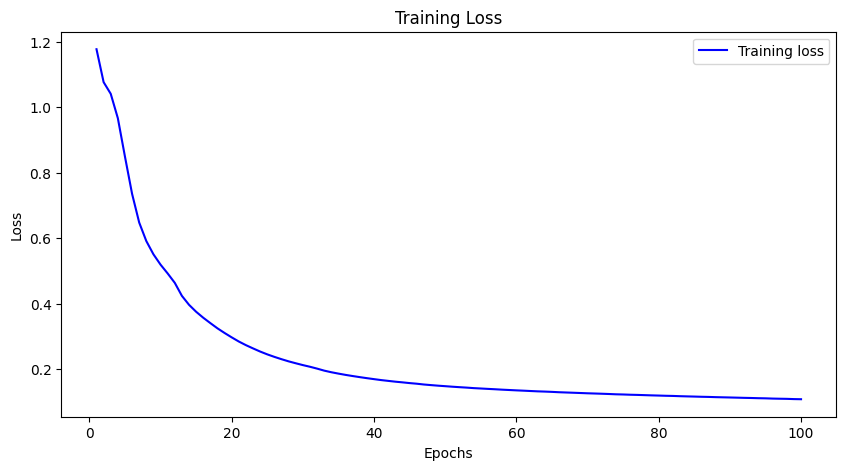

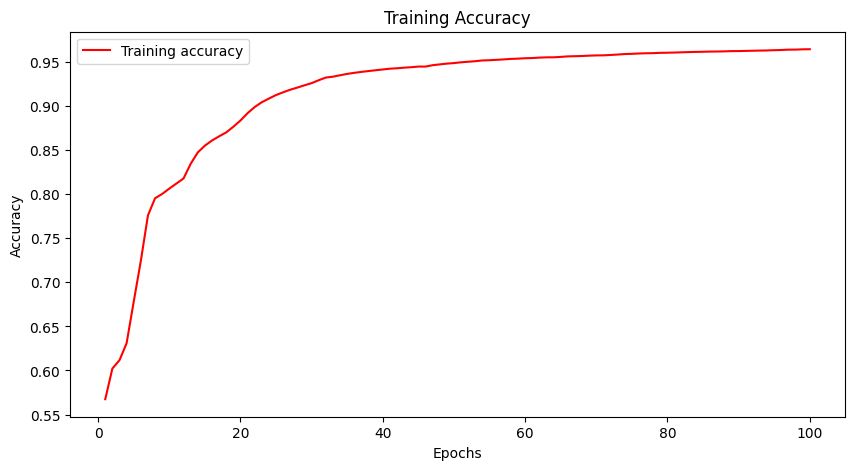

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.1341
GAT(
  (conv1): GATConv(3, 16, heads=8)
  (convs): ModuleList(
    (0-1): 2 x GATConv(128, 16, heads=8)
  )
  (conv2): GATConv(128, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6036
Epoch 2, Val Accuracy: 0.6036
Epoch 3, Val Accuracy: 0.6813
Epoch 4, Val Accuracy: 0.8073
Epoch 5, Val Accuracy: 0.8963
Epoch 6, Val Accuracy: 0.8313
Epoch 7, Val Accuracy: 0.9359
Epoch 8, Val Accuracy: 0.9178
Epoch 9, Val Accuracy: 0.9442
Epoch 10, Val Accuracy: 0.9595
Epoch 11, Val Accuracy: 0.9679
Epoch 12, Val Accuracy: 0.9637
Epoch 13, Val Accuracy: 0.9732
Epoch 14, Val Accuracy: 0.9759
Epoch 15, Val Accuracy: 0.6024
Epoch 16, Val Accuracy: 0.6016
Epoch 17, Val Accuracy: 0.6046
Epoch 18, Val Accuracy: 0.6071
Epoch 19, Val Accuracy: 0.6287
Epoch 20, Val Accuracy: 0.6341
Epoch 21, Val Accuracy: 0.6367
Epoch 22, Val Accuracy: 0.6540
Epoc

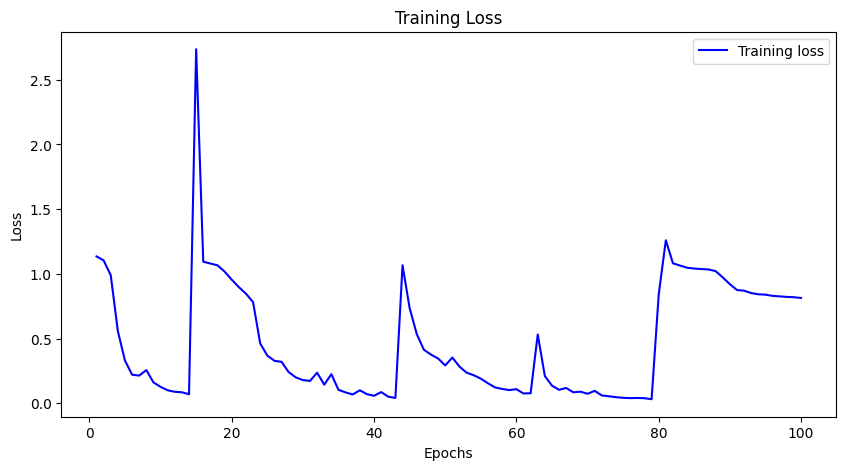

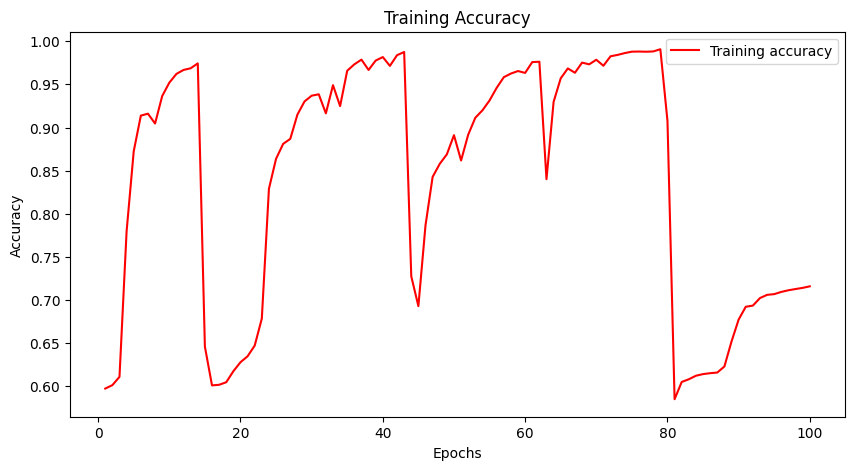

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.4537
GAT(
  (conv1): GATConv(3, 16, heads=8)
  (convs): ModuleList(
    (0-1): 2 x GATConv(128, 16, heads=8)
  )
  (conv2): GATConv(128, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6036
Epoch 2, Val Accuracy: 0.6044
Epoch 3, Val Accuracy: 0.6711
Epoch 4, Val Accuracy: 0.7698
Epoch 5, Val Accuracy: 0.6757
Epoch 6, Val Accuracy: 0.8673
Epoch 7, Val Accuracy: 0.8876
Epoch 8, Val Accuracy: 0.9145
Epoch 9, Val Accuracy: 0.9239
Epoch 10, Val Accuracy: 0.9358
Epoch 11, Val Accuracy: 0.9385
Epoch 12, Val Accuracy: 0.9467
Epoch 13, Val Accuracy: 0.5665
Epoch 14, Val Accuracy: 0.8676
Epoch 15, Val Accuracy: 0.9031
Epoch 16, Val Accuracy: 0.9268
Epoch 17, Val Accuracy: 0.9383
Epoch 18, Val Accuracy: 0.9461
Epoch 19, Val Accuracy: 0.9502
Epoch 20, Val Accuracy: 0.9543
Epoch 21, Val Accuracy: 0.9554
Epoch 22, Val Accuracy: 0.9566
Epoc

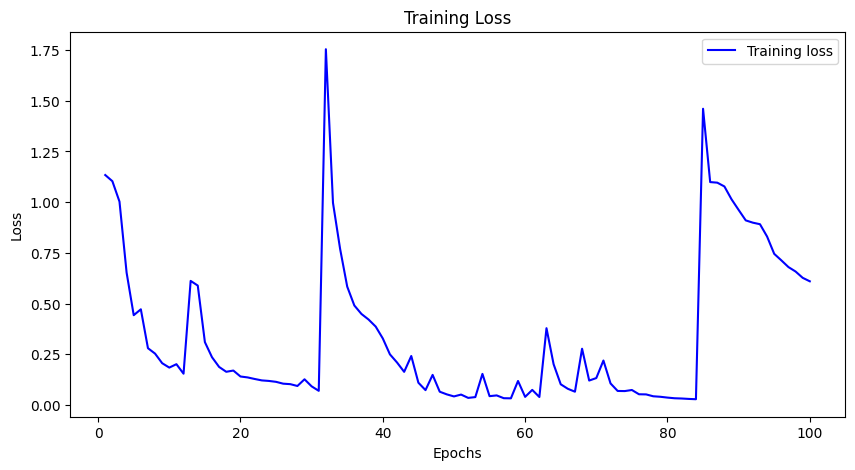

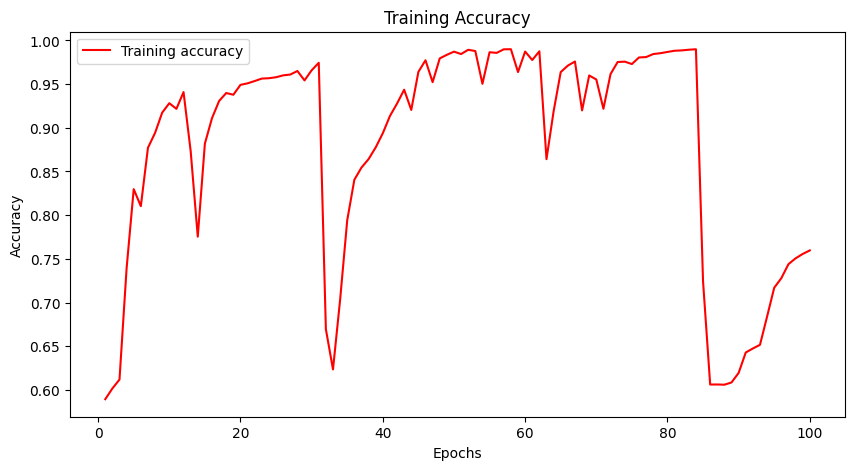

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.2892
GAT(
  (conv1): GATConv(3, 16, heads=8)
  (convs): ModuleList(
    (0-1): 2 x GATConv(128, 16, heads=8)
  )
  (conv2): GATConv(128, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6036
Epoch 2, Val Accuracy: 0.6036
Epoch 3, Val Accuracy: 0.6036
Epoch 4, Val Accuracy: 0.6036
Epoch 5, Val Accuracy: 0.6055
Epoch 6, Val Accuracy: 0.6048
Epoch 7, Val Accuracy: 0.6069
Epoch 8, Val Accuracy: 0.6634
Epoch 9, Val Accuracy: 0.7693
Epoch 10, Val Accuracy: 0.8350
Epoch 11, Val Accuracy: 0.8578
Epoch 12, Val Accuracy: 0.8751
Epoch 13, Val Accuracy: 0.8934
Epoch 14, Val Accuracy: 0.9036
Epoch 15, Val Accuracy: 0.9134
Epoch 16, Val Accuracy: 0.9254
Epoch 17, Val Accuracy: 0.9238
Epoch 18, Val Accuracy: 0.9333
Epoch 19, Val Accuracy: 0.9284
Epoch 20, Val Accuracy: 0.9412
Epoch 21, Val Accuracy: 0.9504
Epoch 22, Val Accuracy: 0.9550
Epoc

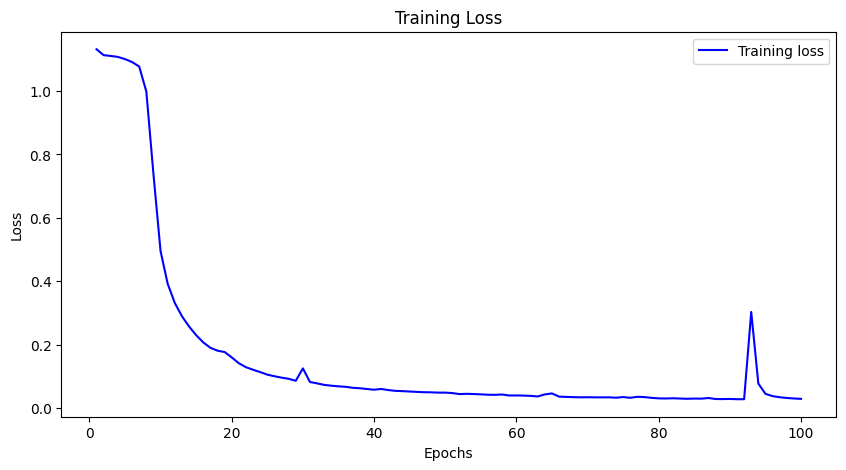

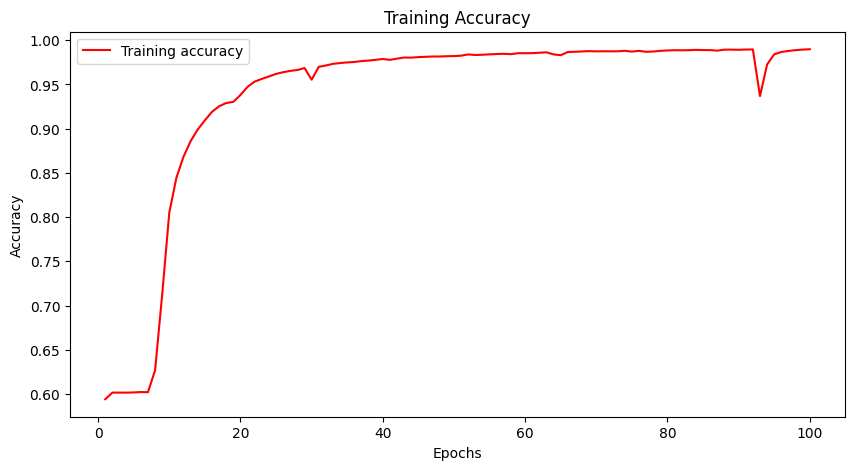

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.1412
GAT(
  (conv1): GATConv(3, 16, heads=8)
  (convs): ModuleList(
    (0-1): 2 x GATConv(128, 16, heads=8)
  )
  (conv2): GATConv(128, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6036
Epoch 2, Val Accuracy: 0.6036
Epoch 3, Val Accuracy: 0.6025
Epoch 4, Val Accuracy: 0.6036
Epoch 5, Val Accuracy: 0.6056
Epoch 6, Val Accuracy: 0.6048
Epoch 7, Val Accuracy: 0.6033
Epoch 8, Val Accuracy: 0.6684
Epoch 9, Val Accuracy: 0.7154
Epoch 10, Val Accuracy: 0.7364
Epoch 11, Val Accuracy: 0.7498
Epoch 12, Val Accuracy: 0.7607
Epoch 13, Val Accuracy: 0.7665
Epoch 14, Val Accuracy: 0.7751
Epoch 15, Val Accuracy: 0.7827
Epoch 16, Val Accuracy: 0.7894
Epoch 17, Val Accuracy: 0.7938
Epoch 18, Val Accuracy: 0.8008
Epoch 19, Val Accuracy: 0.8279
Epoch 20, Val Accuracy: 0.8385
Epoch 21, Val Accuracy: 0.8442
Epoch 22, Val Accuracy: 0.8509
Epoc

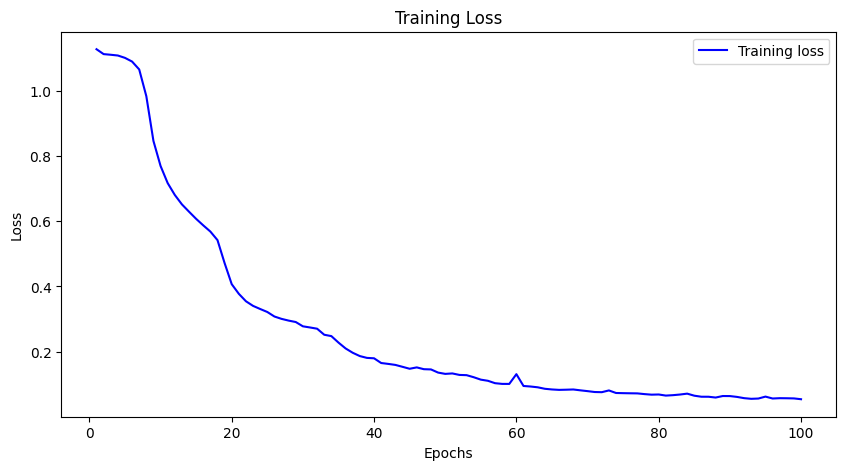

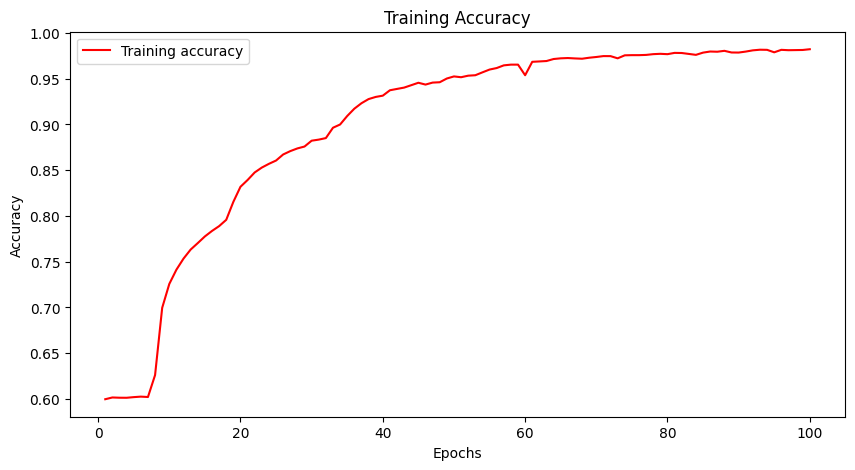

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.1466
GAT(
  (conv1): GATConv(3, 16, heads=8)
  (convs): ModuleList(
    (0-5): 6 x GATConv(128, 16, heads=8)
  )
  (conv2): GATConv(128, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6012
Epoch 2, Val Accuracy: 0.6034
Epoch 3, Val Accuracy: 0.6076
Epoch 4, Val Accuracy: 0.6076
Epoch 5, Val Accuracy: 0.6078
Epoch 6, Val Accuracy: 0.6079
Epoch 7, Val Accuracy: 0.6078
Epoch 8, Val Accuracy: 0.6078
Epoch 9, Val Accuracy: 0.6078
Epoch 10, Val Accuracy: 0.6078
Epoch 11, Val Accuracy: 0.6078
Epoch 12, Val Accuracy: 0.6078
Epoch 13, Val Accuracy: 0.6078
Epoch 14, Val Accuracy: 0.6078
Epoch 15, Val Accuracy: 0.6078
Epoch 16, Val Accuracy: 0.6078
Epoch 17, Val Accuracy: 0.6078
Epoch 18, Val Accuracy: 0.6078
Epoch 19, Val Accuracy: 0.6078
Epoch 20, Val Accuracy: 0.6078
Epoch 21, Val Accuracy: 0.6078
Epoch 22, Val Accuracy: 0.6077
Epoc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


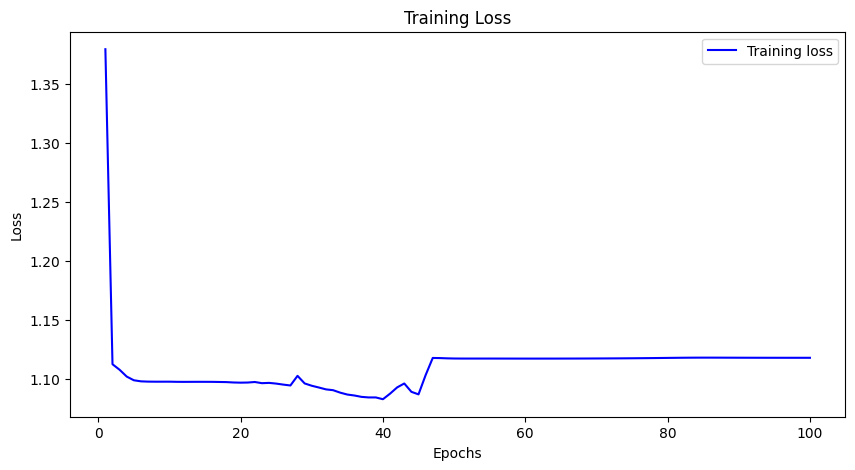

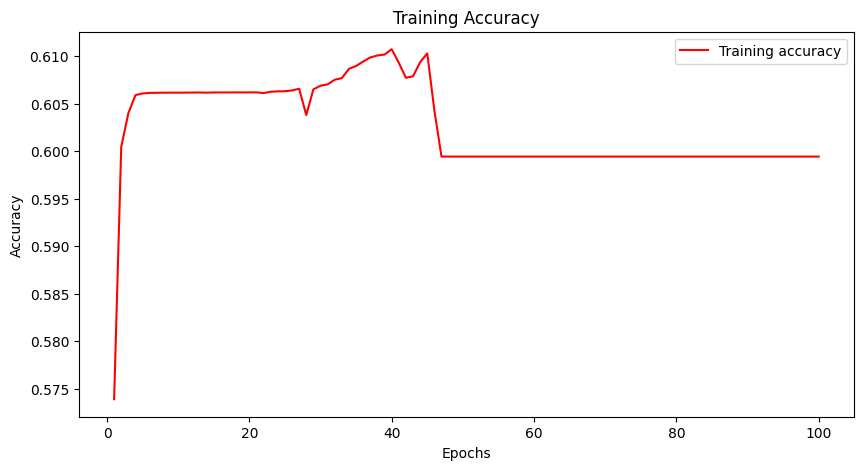

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.1224
GAT(
  (conv1): GATConv(3, 16, heads=8)
  (convs): ModuleList(
    (0-5): 6 x GATConv(128, 16, heads=8)
  )
  (conv2): GATConv(128, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6012
Epoch 2, Val Accuracy: 0.6012
Epoch 3, Val Accuracy: 0.6022
Epoch 4, Val Accuracy: 0.6031
Epoch 5, Val Accuracy: 0.6078
Epoch 6, Val Accuracy: 0.6079
Epoch 7, Val Accuracy: 0.6079
Epoch 8, Val Accuracy: 0.6079
Epoch 9, Val Accuracy: 0.6079
Epoch 10, Val Accuracy: 0.6078
Epoch 11, Val Accuracy: 0.6078
Epoch 12, Val Accuracy: 0.6079
Epoch 13, Val Accuracy: 0.6078
Epoch 14, Val Accuracy: 0.6078
Epoch 15, Val Accuracy: 0.6078
Epoch 16, Val Accuracy: 0.6078
Epoch 17, Val Accuracy: 0.6079
Epoch 18, Val Accuracy: 0.6079
Epoch 19, Val Accuracy: 0.6079
Epoch 20, Val Accuracy: 0.6079
Epoch 21, Val Accuracy: 0.6078
Epoch 22, Val Accuracy: 0.6078
Epoc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


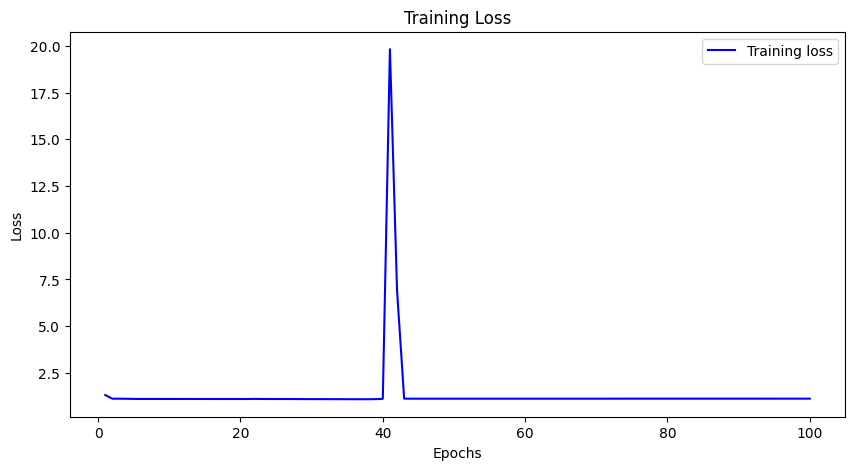

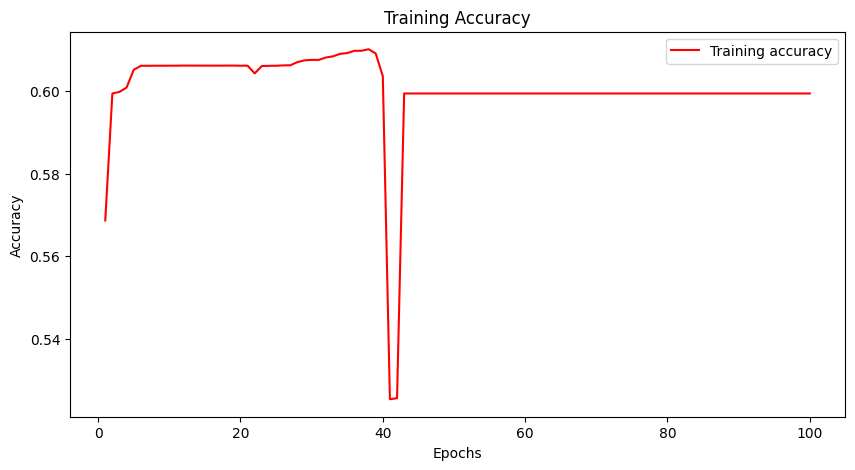

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.5939
GAT(
  (conv1): GATConv(3, 16, heads=8)
  (convs): ModuleList(
    (0-5): 6 x GATConv(128, 16, heads=8)
  )
  (conv2): GATConv(128, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6012
Epoch 2, Val Accuracy: 0.6034
Epoch 3, Val Accuracy: 0.6035
Epoch 4, Val Accuracy: 0.6057
Epoch 5, Val Accuracy: 0.6075
Epoch 6, Val Accuracy: 0.6077
Epoch 7, Val Accuracy: 0.6078
Epoch 8, Val Accuracy: 0.6078
Epoch 9, Val Accuracy: 0.6078
Epoch 10, Val Accuracy: 0.6078
Epoch 11, Val Accuracy: 0.6078
Epoch 12, Val Accuracy: 0.6078
Epoch 13, Val Accuracy: 0.6078
Epoch 14, Val Accuracy: 0.6078
Epoch 15, Val Accuracy: 0.6078
Epoch 16, Val Accuracy: 0.6078
Epoch 17, Val Accuracy: 0.6078
Epoch 18, Val Accuracy: 0.6079
Epoch 19, Val Accuracy: 0.6079
Epoch 20, Val Accuracy: 0.6079
Epoch 21, Val Accuracy: 0.6078
Epoch 22, Val Accuracy: 0.6079
Epoc

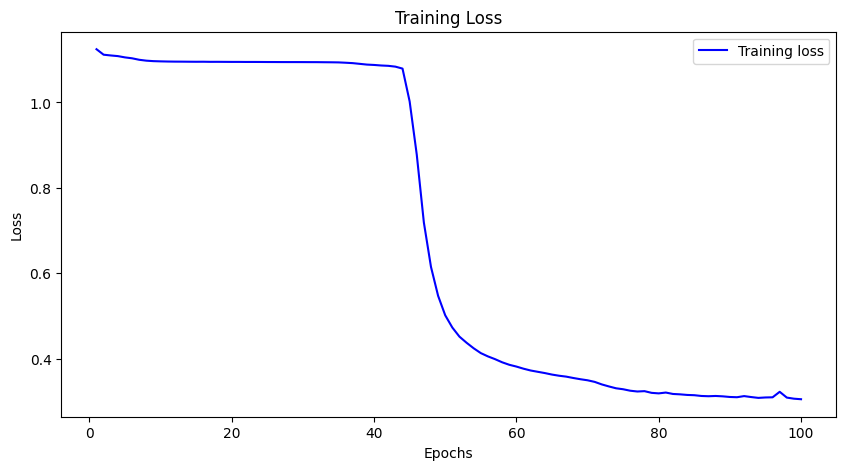

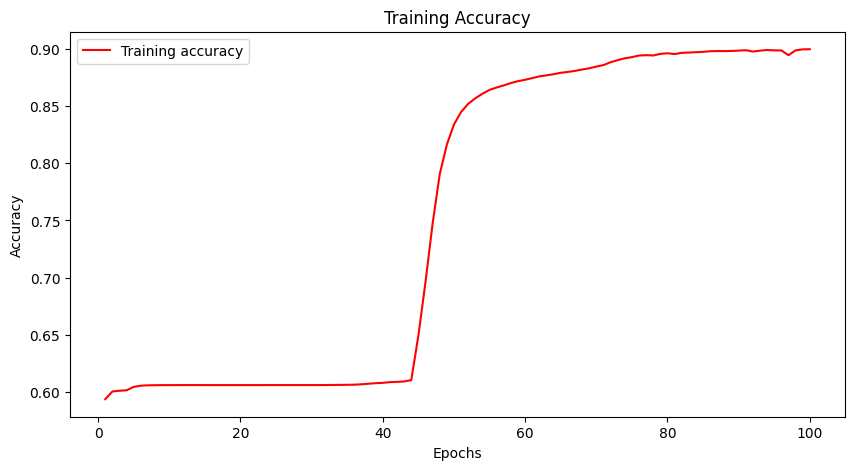

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.1387
GAT(
  (conv1): GATConv(3, 16, heads=8)
  (convs): ModuleList(
    (0-5): 6 x GATConv(128, 16, heads=8)
  )
  (conv2): GATConv(128, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6012
Epoch 2, Val Accuracy: 0.6012
Epoch 3, Val Accuracy: 0.6012
Epoch 4, Val Accuracy: 0.6036
Epoch 5, Val Accuracy: 0.6058
Epoch 6, Val Accuracy: 0.6076
Epoch 7, Val Accuracy: 0.6073
Epoch 8, Val Accuracy: 0.6077
Epoch 9, Val Accuracy: 0.6078
Epoch 10, Val Accuracy: 0.6077
Epoch 11, Val Accuracy: 0.6078
Epoch 12, Val Accuracy: 0.6078
Epoch 13, Val Accuracy: 0.6078
Epoch 14, Val Accuracy: 0.6078
Epoch 15, Val Accuracy: 0.6078
Epoch 16, Val Accuracy: 0.6078
Epoch 17, Val Accuracy: 0.6077
Epoch 18, Val Accuracy: 0.6077
Epoch 19, Val Accuracy: 0.6077
Epoch 20, Val Accuracy: 0.6077
Epoch 21, Val Accuracy: 0.6078
Epoch 22, Val Accuracy: 0.6078
Epoc

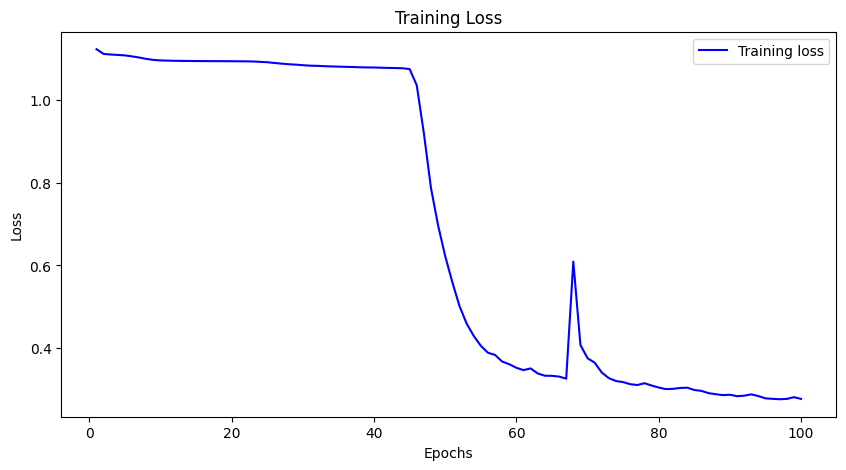

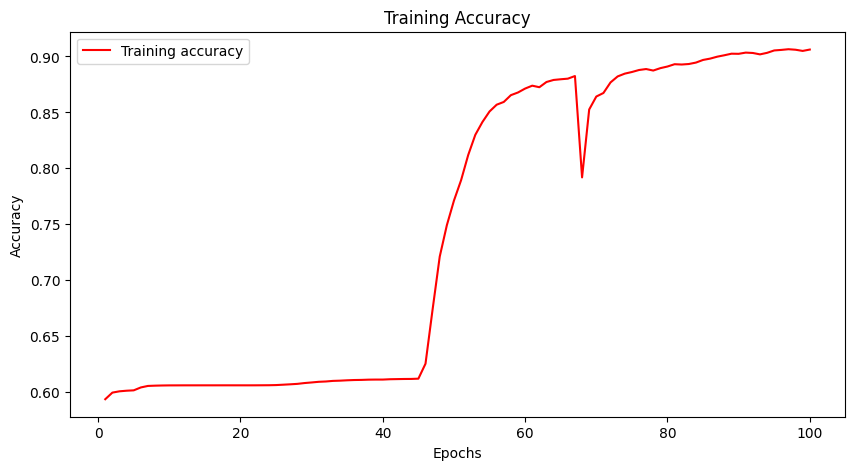

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.4978
GAT(
  (conv1): GATConv(3, 32, heads=8)
  (convs): ModuleList()
  (conv2): GATConv(256, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6927
Epoch 2, Val Accuracy: 0.8021
Epoch 3, Val Accuracy: 0.8397
Epoch 4, Val Accuracy: 0.8657
Epoch 5, Val Accuracy: 0.8447
Epoch 6, Val Accuracy: 0.8916
Epoch 7, Val Accuracy: 0.8979
Epoch 8, Val Accuracy: 0.9084
Epoch 9, Val Accuracy: 0.9076
Epoch 10, Val Accuracy: 0.9167
Epoch 11, Val Accuracy: 0.9238
Epoch 12, Val Accuracy: 0.9273
Epoch 13, Val Accuracy: 0.9327
Epoch 14, Val Accuracy: 0.9353
Epoch 15, Val Accuracy: 0.9357
Epoch 16, Val Accuracy: 0.9346
Epoch 17, Val Accuracy: 0.9392
Epoch 18, Val Accuracy: 0.9424
Epoch 19, Val Accuracy: 0.9404
Epoch 20, Val Accuracy: 0.9415
Epoch 21, Val Accuracy: 0.9428
Epoch 22, Val Accuracy: 0.9450
Epoch 23, Val Accuracy: 0.9453
Epoch 24, Val Acc

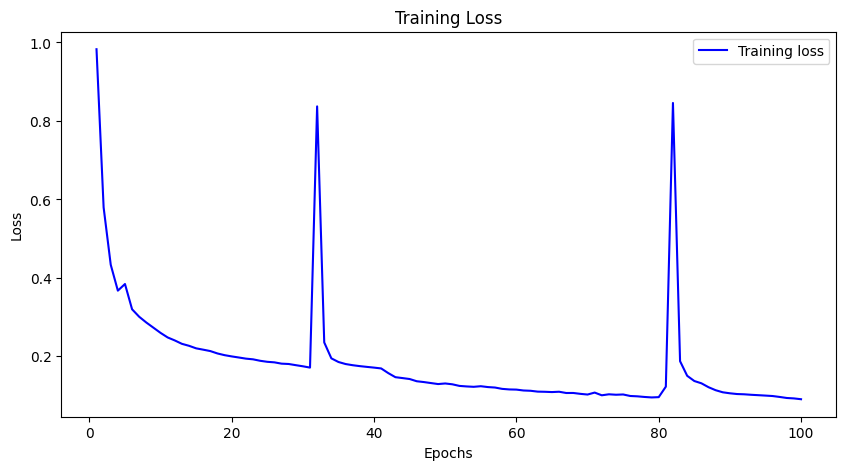

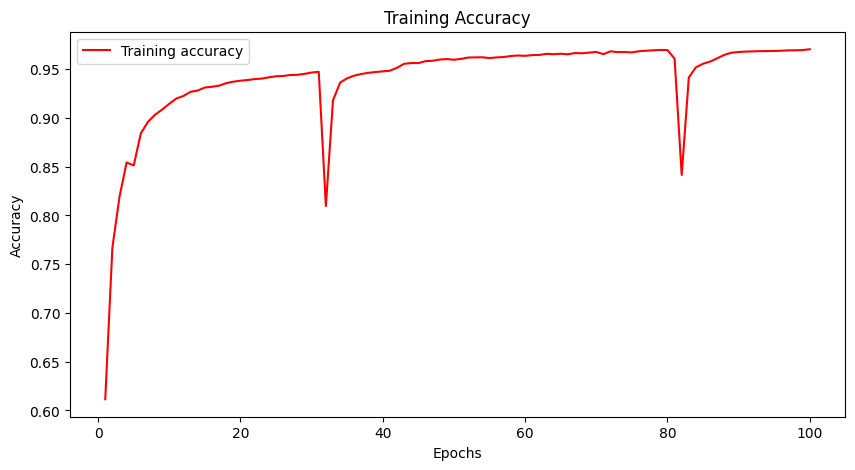

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.1458
GAT(
  (conv1): GATConv(3, 32, heads=8)
  (convs): ModuleList()
  (conv2): GATConv(256, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6780
Epoch 2, Val Accuracy: 0.7788
Epoch 3, Val Accuracy: 0.8182
Epoch 4, Val Accuracy: 0.8389
Epoch 5, Val Accuracy: 0.8606
Epoch 6, Val Accuracy: 0.8701
Epoch 7, Val Accuracy: 0.8736
Epoch 8, Val Accuracy: 0.8846
Epoch 9, Val Accuracy: 0.8811
Epoch 10, Val Accuracy: 0.8857
Epoch 11, Val Accuracy: 0.8931
Epoch 12, Val Accuracy: 0.8980
Epoch 13, Val Accuracy: 0.8887
Epoch 14, Val Accuracy: 0.8995
Epoch 15, Val Accuracy: 0.9127
Epoch 16, Val Accuracy: 0.9149
Epoch 17, Val Accuracy: 0.9048
Epoch 18, Val Accuracy: 0.9076
Epoch 19, Val Accuracy: 0.9118
Epoch 20, Val Accuracy: 0.9225
Epoch 21, Val Accuracy: 0.9212
Epoch 22, Val Accuracy: 0.9311
Epoch 23, Val Accuracy: 0.9265
Epoch 24, Val Acc

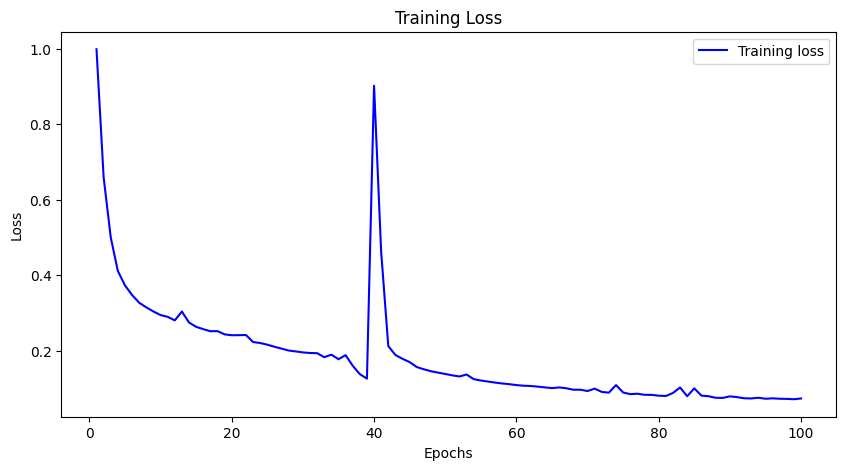

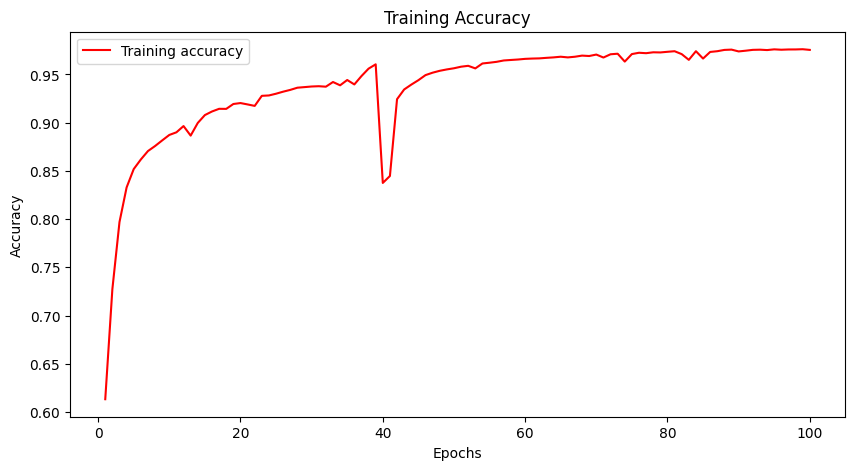

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.1488
GAT(
  (conv1): GATConv(3, 32, heads=8)
  (convs): ModuleList()
  (conv2): GATConv(256, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6000
Epoch 2, Val Accuracy: 0.6150
Epoch 3, Val Accuracy: 0.6566
Epoch 4, Val Accuracy: 0.6538
Epoch 5, Val Accuracy: 0.7298
Epoch 6, Val Accuracy: 0.7670
Epoch 7, Val Accuracy: 0.8201
Epoch 8, Val Accuracy: 0.8356
Epoch 9, Val Accuracy: 0.8518
Epoch 10, Val Accuracy: 0.8646
Epoch 11, Val Accuracy: 0.8763
Epoch 12, Val Accuracy: 0.8862
Epoch 13, Val Accuracy: 0.8920
Epoch 14, Val Accuracy: 0.8950
Epoch 15, Val Accuracy: 0.8989
Epoch 16, Val Accuracy: 0.9005
Epoch 17, Val Accuracy: 0.9033
Epoch 18, Val Accuracy: 0.9052
Epoch 19, Val Accuracy: 0.9069
Epoch 20, Val Accuracy: 0.9110
Epoch 21, Val Accuracy: 0.9139
Epoch 22, Val Accuracy: 0.9162
Epoch 23, Val Accuracy: 0.9188
Epoch 24, Val Acc

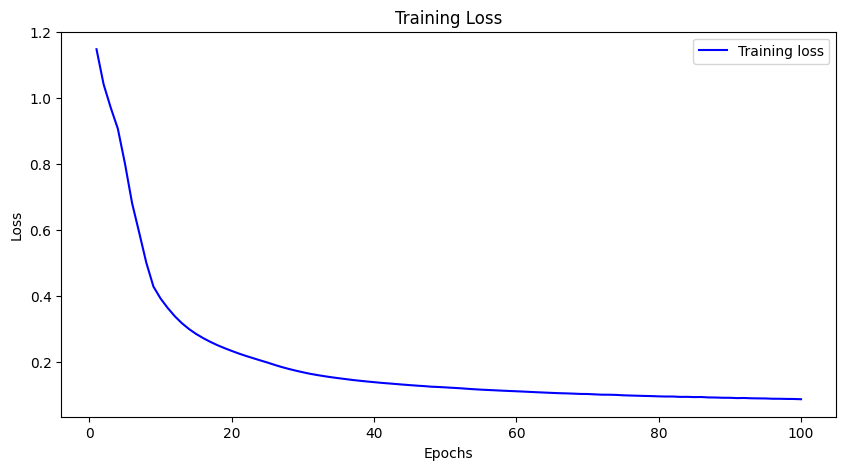

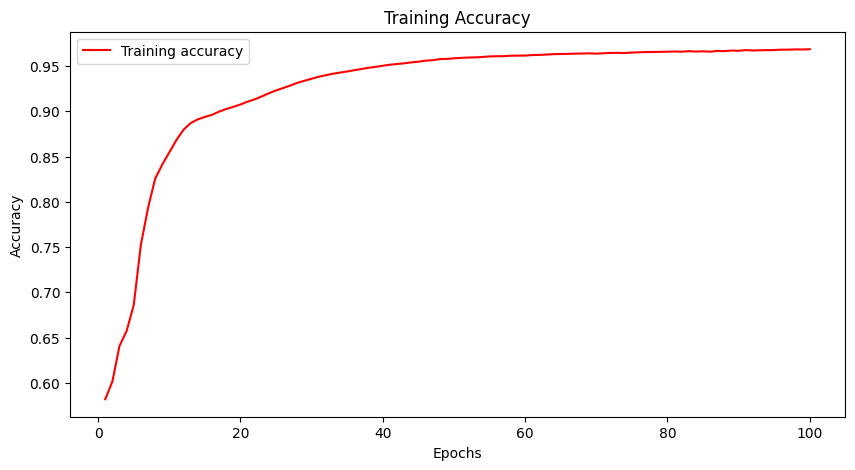

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.5804
GAT(
  (conv1): GATConv(3, 32, heads=8)
  (convs): ModuleList()
  (conv2): GATConv(256, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6040
Epoch 2, Val Accuracy: 0.6059
Epoch 3, Val Accuracy: 0.6373
Epoch 4, Val Accuracy: 0.7350
Epoch 5, Val Accuracy: 0.8099
Epoch 6, Val Accuracy: 0.8378
Epoch 7, Val Accuracy: 0.8646
Epoch 8, Val Accuracy: 0.8792
Epoch 9, Val Accuracy: 0.8922
Epoch 10, Val Accuracy: 0.9046
Epoch 11, Val Accuracy: 0.9103
Epoch 12, Val Accuracy: 0.9179
Epoch 13, Val Accuracy: 0.9243
Epoch 14, Val Accuracy: 0.9276
Epoch 15, Val Accuracy: 0.9317
Epoch 16, Val Accuracy: 0.9383
Epoch 17, Val Accuracy: 0.9417
Epoch 18, Val Accuracy: 0.9446
Epoch 19, Val Accuracy: 0.9470
Epoch 20, Val Accuracy: 0.9496
Epoch 21, Val Accuracy: 0.9507
Epoch 22, Val Accuracy: 0.9519
Epoch 23, Val Accuracy: 0.9528
Epoch 24, Val Acc

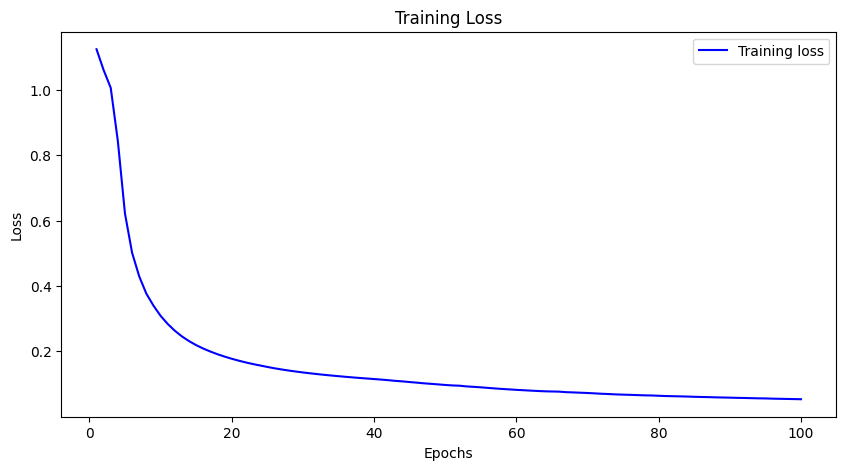

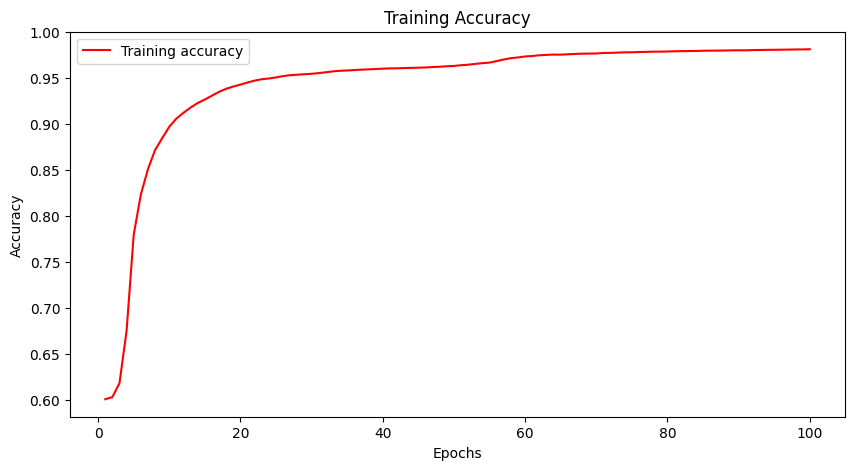

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.3848
GAT(
  (conv1): GATConv(3, 32, heads=8)
  (convs): ModuleList(
    (0-1): 2 x GATConv(256, 32, heads=8)
  )
  (conv2): GATConv(256, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6035
Epoch 2, Val Accuracy: 0.6026
Epoch 3, Val Accuracy: 0.6050
Epoch 4, Val Accuracy: 0.6827
Epoch 5, Val Accuracy: 0.6668
Epoch 6, Val Accuracy: 0.7577
Epoch 7, Val Accuracy: 0.7856
Epoch 8, Val Accuracy: 0.8382
Epoch 9, Val Accuracy: 0.6077
Epoch 10, Val Accuracy: 0.7798
Epoch 11, Val Accuracy: 0.8181
Epoch 12, Val Accuracy: 0.8695
Epoch 13, Val Accuracy: 0.8318
Epoch 14, Val Accuracy: 0.6117
Epoch 15, Val Accuracy: 0.7687
Epoch 16, Val Accuracy: 0.8101
Epoch 17, Val Accuracy: 0.8274
Epoch 18, Val Accuracy: 0.8419
Epoch 19, Val Accuracy: 0.8443
Epoch 20, Val Accuracy: 0.8483
Epoch 21, Val Accuracy: 0.8489
Epoch 22, Val Accuracy: 0.8332
Epoc

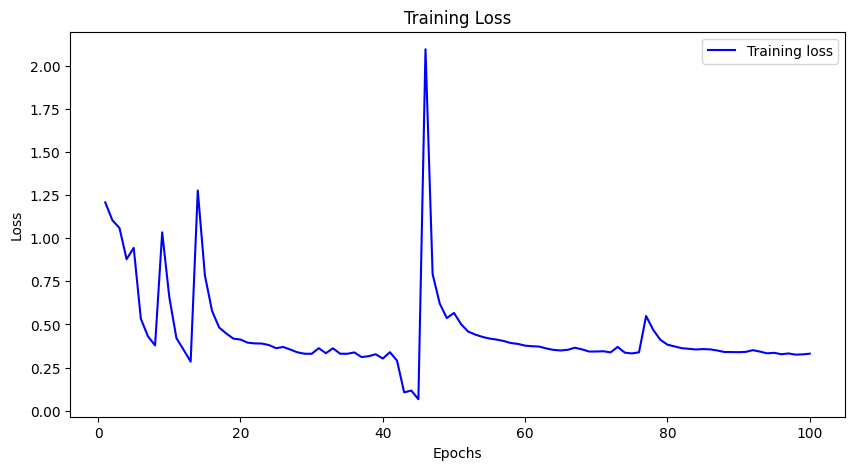

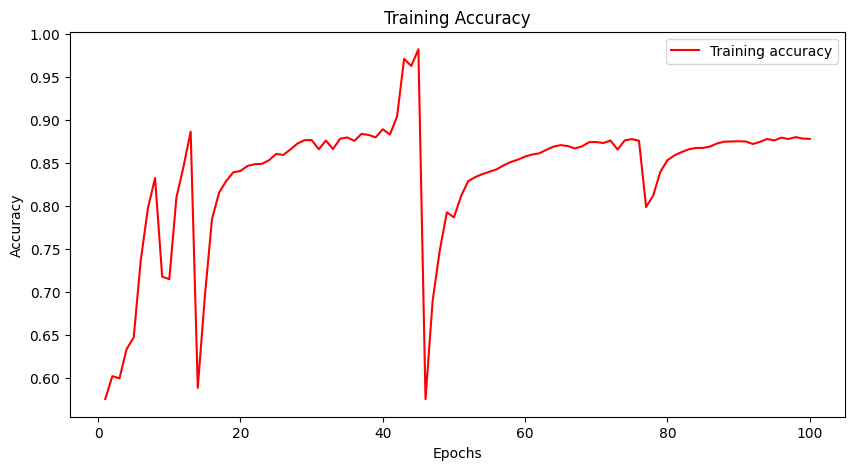

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.1660
GAT(
  (conv1): GATConv(3, 32, heads=8)
  (convs): ModuleList(
    (0-1): 2 x GATConv(256, 32, heads=8)
  )
  (conv2): GATConv(256, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6041
Epoch 2, Val Accuracy: 0.6045
Epoch 3, Val Accuracy: 0.6039
Epoch 4, Val Accuracy: 0.6208
Epoch 5, Val Accuracy: 0.6633
Epoch 6, Val Accuracy: 0.7639
Epoch 7, Val Accuracy: 0.8066
Epoch 8, Val Accuracy: 0.8217
Epoch 9, Val Accuracy: 0.8269
Epoch 10, Val Accuracy: 0.8344
Epoch 11, Val Accuracy: 0.8369
Epoch 12, Val Accuracy: 0.8310
Epoch 13, Val Accuracy: 0.8396
Epoch 14, Val Accuracy: 0.8424
Epoch 15, Val Accuracy: 0.5708
Epoch 16, Val Accuracy: 0.6077
Epoch 17, Val Accuracy: 0.6072
Epoch 18, Val Accuracy: 0.6398
Epoch 19, Val Accuracy: 0.7399
Epoch 20, Val Accuracy: 0.7671
Epoch 21, Val Accuracy: 0.7796
Epoch 22, Val Accuracy: 0.8075
Epoc

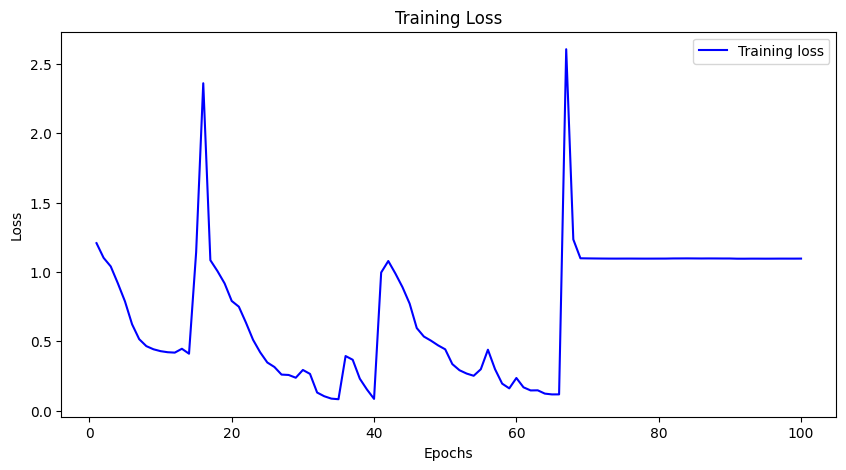

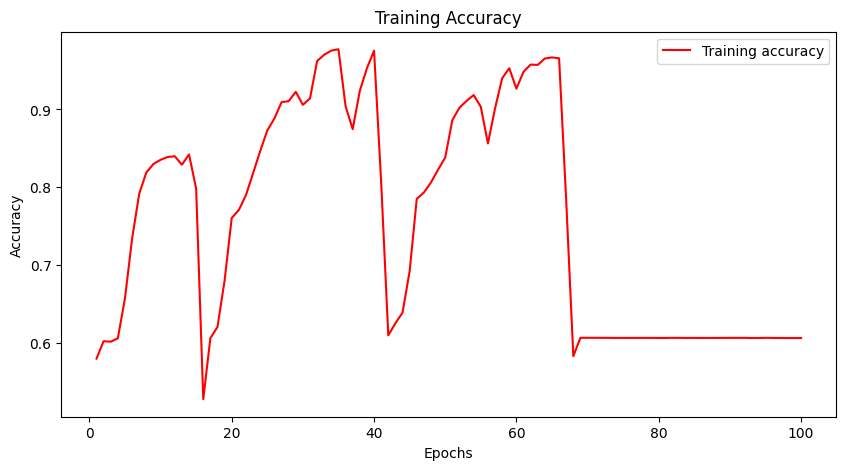

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.1215
GAT(
  (conv1): GATConv(3, 32, heads=8)
  (convs): ModuleList(
    (0-1): 2 x GATConv(256, 32, heads=8)
  )
  (conv2): GATConv(256, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6036
Epoch 2, Val Accuracy: 0.6025
Epoch 3, Val Accuracy: 0.6034
Epoch 4, Val Accuracy: 0.6026
Epoch 5, Val Accuracy: 0.6029
Epoch 6, Val Accuracy: 0.5913
Epoch 7, Val Accuracy: 0.6285
Epoch 8, Val Accuracy: 0.7058
Epoch 9, Val Accuracy: 0.8232
Epoch 10, Val Accuracy: 0.8575
Epoch 11, Val Accuracy: 0.8985
Epoch 12, Val Accuracy: 0.9134
Epoch 13, Val Accuracy: 0.9230
Epoch 14, Val Accuracy: 0.9356
Epoch 15, Val Accuracy: 0.9352
Epoch 16, Val Accuracy: 0.9424
Epoch 17, Val Accuracy: 0.9470
Epoch 18, Val Accuracy: 0.9504
Epoch 19, Val Accuracy: 0.9564
Epoch 20, Val Accuracy: 0.9604
Epoch 21, Val Accuracy: 0.9496
Epoch 22, Val Accuracy: 0.9622
Epoc

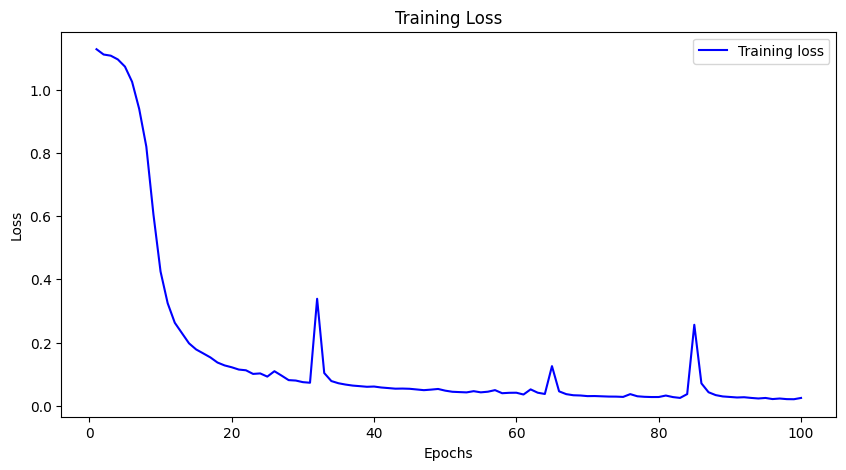

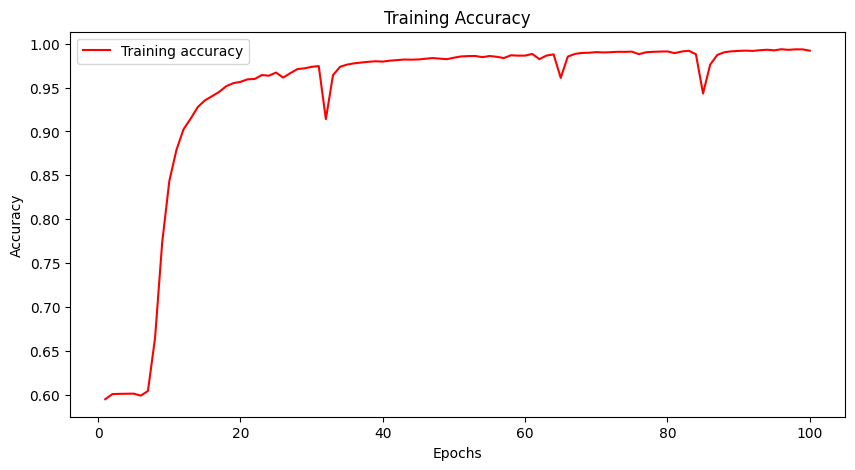

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.4948
GAT(
  (conv1): GATConv(3, 32, heads=8)
  (convs): ModuleList(
    (0-1): 2 x GATConv(256, 32, heads=8)
  )
  (conv2): GATConv(256, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6036
Epoch 2, Val Accuracy: 0.6012
Epoch 3, Val Accuracy: 0.6035
Epoch 4, Val Accuracy: 0.6046
Epoch 5, Val Accuracy: 0.5969
Epoch 6, Val Accuracy: 0.6556
Epoch 7, Val Accuracy: 0.7767
Epoch 8, Val Accuracy: 0.8487
Epoch 9, Val Accuracy: 0.8908
Epoch 10, Val Accuracy: 0.9133
Epoch 11, Val Accuracy: 0.9275
Epoch 12, Val Accuracy: 0.9388
Epoch 13, Val Accuracy: 0.9359
Epoch 14, Val Accuracy: 0.9580
Epoch 15, Val Accuracy: 0.9623
Epoch 16, Val Accuracy: 0.9652
Epoch 17, Val Accuracy: 0.9703
Epoch 18, Val Accuracy: 0.9703
Epoch 19, Val Accuracy: 0.9724
Epoch 20, Val Accuracy: 0.9761
Epoch 21, Val Accuracy: 0.9722
Epoch 22, Val Accuracy: 0.9646
Epoc

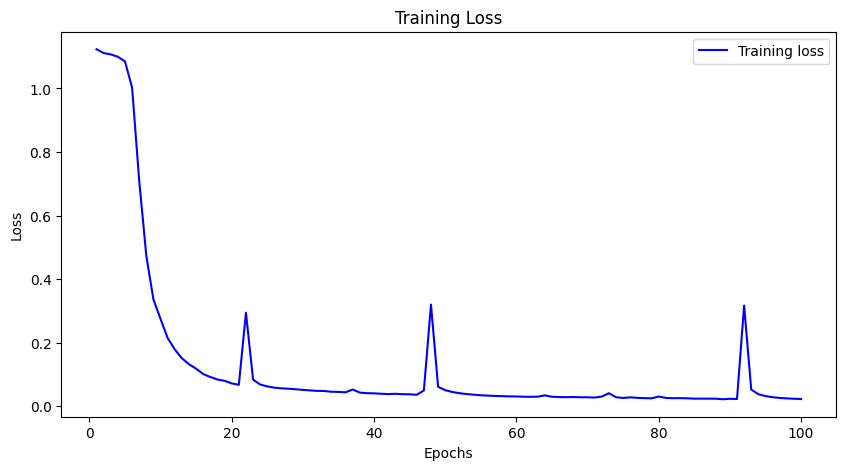

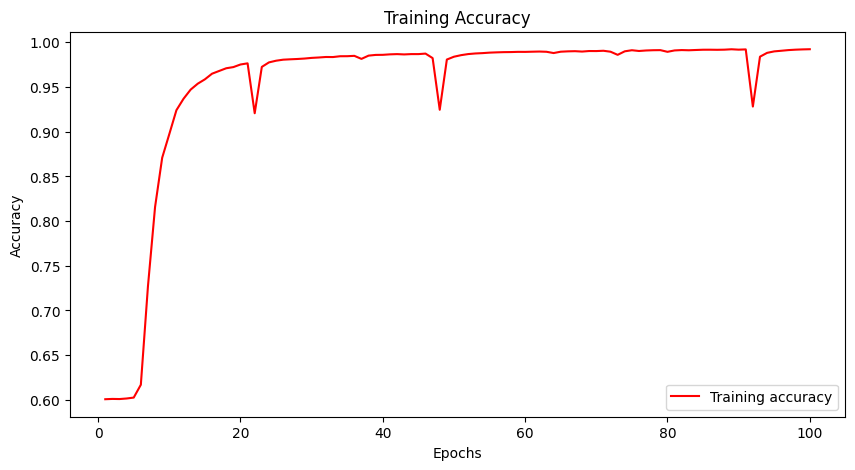

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.1361
GAT(
  (conv1): GATConv(3, 32, heads=8)
  (convs): ModuleList(
    (0-5): 6 x GATConv(256, 32, heads=8)
  )
  (conv2): GATConv(256, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6012
Epoch 2, Val Accuracy: 0.6022
Epoch 3, Val Accuracy: 0.6032
Epoch 4, Val Accuracy: 0.6077
Epoch 5, Val Accuracy: 0.6077
Epoch 6, Val Accuracy: 0.6077
Epoch 7, Val Accuracy: 0.6076
Epoch 8, Val Accuracy: 0.6077
Epoch 9, Val Accuracy: 0.6078
Epoch 10, Val Accuracy: 0.6078
Epoch 11, Val Accuracy: 0.6078
Epoch 12, Val Accuracy: 0.6078
Epoch 13, Val Accuracy: 0.6078
Epoch 14, Val Accuracy: 0.6078
Epoch 15, Val Accuracy: 0.6079
Epoch 16, Val Accuracy: 0.6079
Epoch 17, Val Accuracy: 0.6078
Epoch 18, Val Accuracy: 0.6078
Epoch 19, Val Accuracy: 0.6079
Epoch 20, Val Accuracy: 0.6078
Epoch 21, Val Accuracy: 0.6077
Epoch 22, Val Accuracy: 0.6078
Epoc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


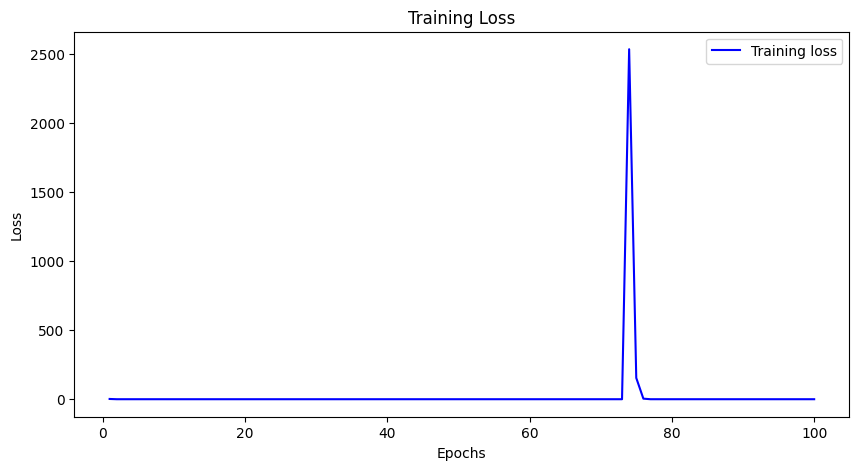

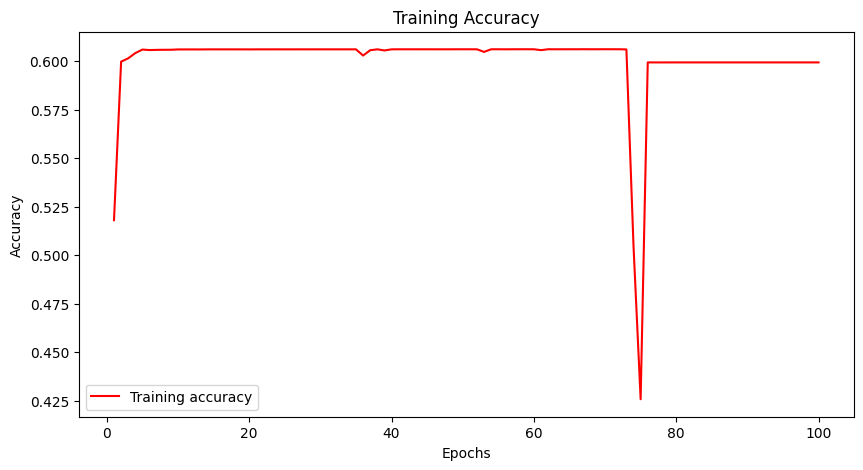

Best Validation Accuracy: 0.9957, Best Hyperparameters: {'hidden_size': 16, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Test Accuracy with Best Hyperparameters: 0.3056
GAT(
  (conv1): GATConv(3, 32, heads=8)
  (convs): ModuleList(
    (0-5): 6 x GATConv(256, 32, heads=8)
  )
  (conv2): GATConv(256, 4, heads=1)
)
Epoch 1, Val Accuracy: 0.6012
Epoch 2, Val Accuracy: 0.6012
Epoch 3, Val Accuracy: 0.6012
Epoch 4, Val Accuracy: 0.6022
Epoch 5, Val Accuracy: 0.6035
Epoch 6, Val Accuracy: 0.6045
Epoch 7, Val Accuracy: 0.6045
Epoch 8, Val Accuracy: 0.6044
Epoch 9, Val Accuracy: 0.6052
Epoch 10, Val Accuracy: 0.6066
Epoch 11, Val Accuracy: 0.6075
Epoch 12, Val Accuracy: 0.6076
Epoch 13, Val Accuracy: 0.6077
Epoch 14, Val Accuracy: 0.6077
Epoch 15, Val Accuracy: 0.6078
Epoch 16, Val Accuracy: 0.6078
Epoch 17, Val Accuracy: 0.6078
Epoch 18, Val Accuracy: 0.6078
Epoch 19, Val Accuracy: 0.6078
Epoch 20, Val Accuracy: 0.6078
Epoch 21, Val Accuracy: 0.6078
Epoch 22, Val Accuracy: 0.6078
Epoc

In [ ]:
# Parameters
num_graphs = 100
distances = [30]
error_rates = [0.4]

# Define hyperparameter configurations
hyperparameters = {
    'hidden_size': [16, 32, 64],
    'num_layers': [2, 4, 8],
    'lr': [0.01, 0.001],
    'weight_decay': [8e-4, 1e-4],
    'epochs': 100,
    # 'batch size': 4096,
    'heads': 8,
    # 'hidden dropout': 0.1,
}

best_accuracy, best_hyperparameters = generate_multiple_graphs(num_graphs, distances, error_rates, hyperparameters)
print("best_accuracy, best_hyperparameters")
print(best_accuracy, best_hyperparameters)